In [1]:
from pathlib import Path
import pandas as pd

In [2]:
DATA_DIR = Path("bumperanalysis")
TZ = "America/New_York"

In [3]:
CSV_FILES = {
    "Cecil Hall": "cecil-hall-T.csv",
    "Fraktur": "fraktur-T.csv",
    "Readborne Passage": "readbourne-passage-T.csv",
    "Nemours": "nemours-T.csv",
    "Readborne Room": "readbourne-room-T.csv",
}

In [30]:
def load_room_csv(path, room_name):
    # skip the first metadata line: "history:WirelessDemo/..."
    df = pd.read_csv(path, skiprows=1)

    # now the columns are: Timestamp, Trend Flags, Status, Value (°F)
    df = df.rename(columns={
        "Timestamp": "timestamp",
        "Value (°F)": "temp_F"
    })

    # remove timezone (EDT) from the string
    df["timestamp"] = df["timestamp"].str.replace(r"\s[A-Z]{3}$", "", regex=True)

    # parse timestamp explicitly to avoid warnings
    df["timestamp"] = pd.to_datetime(
        df["timestamp"],
        format="%d-%b-%y %I:%M:%S %p",
        errors="coerce"
    )

    df = df.sort_values("timestamp")
    df = df[df["timestamp"] >= "2023-01-01"]

    df["Room"] = room_name
    return df


In [31]:
Cecil_Hall = load_room_csv(DATA_DIR / "cecil-hall-T.csv", "Cecil")
Fraktur = load_room_csv(DATA_DIR / "fraktur-T.csv", "Fraktur")
Readbourne_Passage = load_room_csv(DATA_DIR / "readbourne-passage-T.csv", "Readbourne Passage")
Nemours = load_room_csv(DATA_DIR / "nemours-T.csv", "Nemours")
Readbourne_Room = load_room_csv(DATA_DIR / "readbourne-room-T.csv", "Readbourne Room")

In [34]:
DECAYING_ROOMS = {"Cecil Hall", "Fraktur", "Readbourne Passage"}
CONTROL_ROOMS  = {"Nemours", "Readbourne Room"}

In [35]:
temp_all = pd.concat(
    [Cecil_Hall, Fraktur, Readbourne_Passage, Nemours, Readbourne_Room],
    ignore_index=True
)


In [36]:
temp_all.head()

,timestamp,Trend Flags,Status,temp_F,Room
0,2023-05-04 06:00:00,{ },{ok},68.9,Cecil
1,2023-05-04 06:15:01,{ },{ok},68.9,Cecil
2,2023-05-04 06:30:00,{ },{ok},68.8,Cecil
3,2023-05-04 06:45:00,{ },{ok},69.0,Cecil
4,2023-05-04 07:00:00,{ },{ok},68.9,Cecil


In [37]:
for name, fname in CSV_FILES.items():
    df = pd.read_csv(DATA_DIR / fname)
    print(name, "→", list(df.columns))


Cecil Hall → ['history:WirelessDemo/7th Flr Cecil Hall Temp']
Fraktur → ['history:BoilerRoom/FracF_Temp']
Readborne Passage → ['history:WirelessDemo/Readbourne Passage Temp']
Nemours → ['history:WirelessDemo/Nemours_Room_Temp']
Readborne Room → ['history:BoilerRoom/Readbourne_Temp']


In [38]:
# time step in minutes
temp_all["dt_min"] = (
    temp_all
    .groupby("Room")["timestamp"]
    .diff()
    .dt.total_seconds() / 60.0
)

# change in temperature per step
temp_all["Delta_T"] = (
    temp_all
    .groupby("Room")["temp_F"]
    .diff()
)

# normalize to °F per hour so different dt still comparable
temp_all["Delta_T_per_hr"] = temp_all["Delta_T"] / (temp_all["dt_min"] / 60.0)


In [39]:
def check_intervals(room_name):
    r = temp_all[temp_all["Room"] == room_name].copy()
    r["dt_min"] = r["timestamp"].diff().dt.total_seconds() / 60
    print(room_name, "– unique intervals (minutes):")
    print(r["dt_min"].dropna().unique()[:10])  # show first 10 unique intervals
    print()

check_intervals("Cecil")
check_intervals("Fraktur")
check_intervals("Readbourne Passage")
check_intervals("Nemours")
check_intervals("Readbourne Room")


Cecil – unique intervals (minutes):
[1.50166667e+01 1.49833333e+01 1.50000000e+01 3.00000000e+01
 1.51000000e+01 1.49000000e+01 1.51333333e+01 1.48666667e+01
 0.00000000e+00 1.66666667e-02]

Fraktur – unique intervals (minutes):
[ 15.          15.01666667  14.98333333  15.03333333  14.96666667
  15.05       134.96666667 330.          15.08333333  14.91666667]

Readbourne Passage – unique intervals (minutes):
[15.         14.98333333 15.01666667 14.96666667 30.         15.1
 14.9        15.11666667 14.88333333  0.        ]

Nemours – unique intervals (minutes):
[1.50166667e+01 1.49833333e+01 1.50000000e+01 3.00000000e+01
 1.51000000e+01 1.49000000e+01 1.51333333e+01 1.48666667e+01
 0.00000000e+00 1.66666667e-02]

Readbourne Room – unique intervals (minutes):
[ 15.          15.01666667  14.98333333  15.03333333  14.96666667
  14.95        15.05       134.95       134.96666667 330.        ]



In [41]:
def show_large_intervals(room, threshold=100):
    r = temp_all[temp_all["Room"] == room].copy()
    r["dt_min"] = r["timestamp"].diff().dt.total_seconds() / 60
    large = r[r["dt_min"] > threshold]
    return large[["timestamp", "dt_min"]]

for room in ["Cecil", "Fraktur", "Readbourne Passage", "Nemours", "Readbourne Room"]:
    print("\n---", room, "---")
    print(show_large_intervals(room))



--- Cecil ---
                timestamp   dt_min
63841 2025-04-07 09:45:00  56130.0

--- Fraktur ---
                 timestamp        dt_min
84261  2023-06-07 23:00:01    134.966667
84423  2023-06-09 17:30:01    134.966667
84519  2023-06-10 22:45:01    330.000000
86047  2023-06-26 22:15:01    104.966667
88373  2023-07-21 08:45:02    149.966667
88560  2023-07-23 10:45:01    150.000000
88631  2023-07-24 07:00:00    164.950000
88701  2023-07-25 03:00:00    164.950000
88771  2023-07-25 23:30:01    194.983333
88799  2023-07-26 09:00:00    164.983333
88869  2023-07-27 12:00:01    584.983333
88941  2023-07-28 08:00:00    134.950000
88988  2023-07-28 21:45:00    134.983333
89122  2023-07-31 07:00:00   1394.916667
89614  2023-08-05 13:30:01    135.000000
89686  2023-08-06 09:30:00    134.950000
89758  2023-08-07 05:45:01    149.983333
89805  2023-08-08 05:00:00    705.000000
90190  2023-08-12 08:30:00    164.983333
90370  2023-08-14 16:15:00    659.950000
99940  2023-12-12 07:45:00  28770.000

In [107]:
gaps_30 = temp_all[temp_all["dt_min"] >= 30][["Room", "timestamp", "dt_min"]]
gaps_30 = gaps_30.sort_values(["Room", "timestamp"])
gaps_30

,Room,timestamp,dt_min
6401,Cecil,2023-07-09 22:30:00,30.000000
18497,Cecil,2023-11-12 21:45:00,30.000000
20749,Cecil,2023-12-06 09:00:00,30.000000
24052,Cecil,2024-01-09 19:00:00,30.000000
29484,Cecil,2024-03-06 09:15:00,30.000000
...,...,...,...
373437,Readbourne Room,2024-12-02 08:15:01,150.016667
381118,Readbourne Room,2025-02-20 09:00:01,45.016667
381787,Readbourne Room,2025-02-27 08:30:00,30.000000
381796,Readbourne Room,2025-03-27 12:30:00,40440.000000


In [108]:
gaps_30.groupby("Room").size()


Room
Cecil                 26
Fraktur               38
Nemours               26
Readbourne Passage    27
Readbourne Room       47
dtype: int64

In [53]:
temp_all["dt_min"] = (
    temp_all
    .groupby("Room")["timestamp"]
    .diff()
    .dt.total_seconds() / 60
)

In [58]:
temp_all.groupby("Room")["Delta_T"].describe()


,count,mean,std,min,25%,50%,75%,max
Room,,,,,,,,
Cecil,80933.0,0.000002,1.818812,-74.4,-0.1,0.0,0.0,74.7
Fraktur,77574.0,-0.000010,1.100879,-74.2,-0.3,0.0,0.3,74.7
Nemours,80933.0,0.000020,1.540062,-71.5,0.0,0.0,0.0,71.9
Readbourne Passage,80933.0,-0.000014,2.090766,-72.1,0.0,0.0,0.0,72.3
Readbourne Room,77173.0,-0.000009,122.096338,-23731.8,-0.5,0.0,0.5,24220.5


In [73]:
import numpy as np

clean["Delta_T_per_hr"] = clean["Delta_T_per_hr"].replace(
    [np.inf, -np.inf],
    np.nan
)


In [74]:
clean[np.isinf(clean["Delta_T_per_hr"])]


,timestamp,Trend Flags,Status,temp_F,Room,dt_min,Delta_T,Delta_T_per_hr


In [76]:
summary_clean = (
    clean
    .groupby("Room")["Delta_T_per_hr"]
    .describe()
)

summary_clean


,count,mean,std,min,25%,50%,75%,max
Room,,,,,,,,
Cecil,80925.0,0.008321,7.029512,-297.6,-0.4,0.0,0.0,298.800000
Fraktur,77247.0,0.002339,3.879133,-286.8,-1.2,0.0,1.2,322.407862
Nemours,80925.0,0.008338,5.878941,-286.0,0.0,0.0,0.0,287.600000
Readbourne Passage,80925.0,0.006018,8.195390,-288.4,0.0,0.0,0.0,289.200000
Readbourne Room,77165.0,0.002052,488.406244,-94927.2,-2.0,0.0,2.0,96882.000000


In [136]:
temp_all_copy = temp_all.copy()


In [158]:
temp_all_copy["Delta_T_15min"] = (
    temp_all_copy["Delta_T"] / (temp_all_copy["dt_min"] / 15.0)
)


In [166]:
def plot_rate_15min(room, df):
   
    df_room = df[df["Room"] == room].copy()

    
    df_room = df_room[df_room["dt_min"].between(14, 16)].copy()
    
   
    df_room = df_room.dropna(subset=["Delta_T_15min"])

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df_room["timestamp"], df_room["Delta_T_15min"], lw=0.5)
    ax.axhline(0, linestyle="--", color="black")

    ax.set_title(f"15-Minute Temperature Change (ΔT) — {room}")
    ax.set_ylabel("°F change per 15 minutes")
    ax.set_xlabel("Timestamp")

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # Zoom for clarity
    ax.set_ylim(-1, 1)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [168]:
def plot_rate_15min(room, df):
   
    df_room = df[df["Room"] == room].copy()

  
    df_room = df_room[df_room["dt_min"].between(14, 16)].copy()

    
    df_room["Delta_T_15min"] = df_room["Delta_T"]

   
    df_room = df_room.dropna(subset=["Delta_T_15min"])

    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.scatter(
        df_room["timestamp"],
        df_room["Delta_T_15min"],
        s=5,         
        alpha=0.3   
    )
    ax.axhline(0, linestyle="--", color="black")

    ax.set_title(f"15-Minute Temperature Change (ΔT) — {room}")
    ax.set_ylabel("°F change per 15 minutes")
    ax.set_xlabel("Timestamp")

    # Monthly ticks on x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # Zoom Y axis for clarity
    ax.set_ylim(-2, 2)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

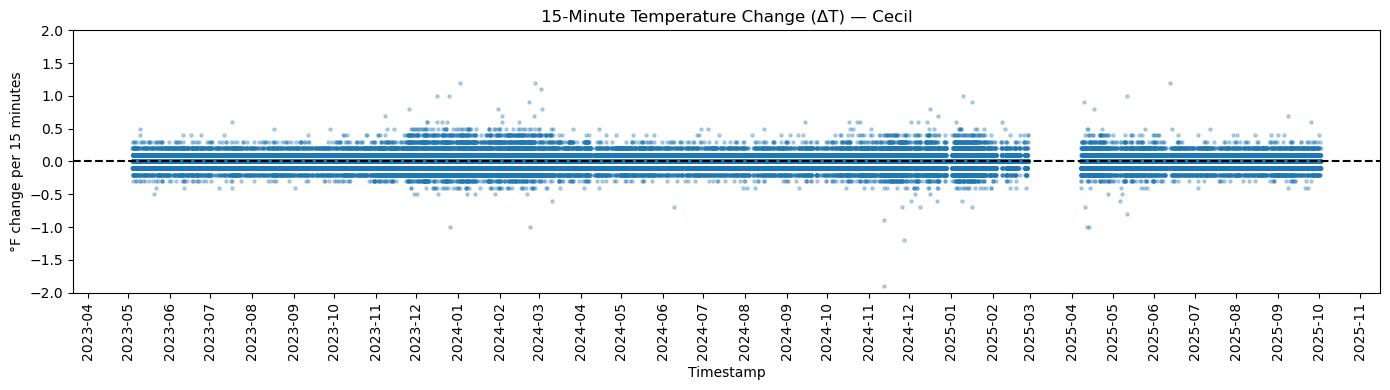

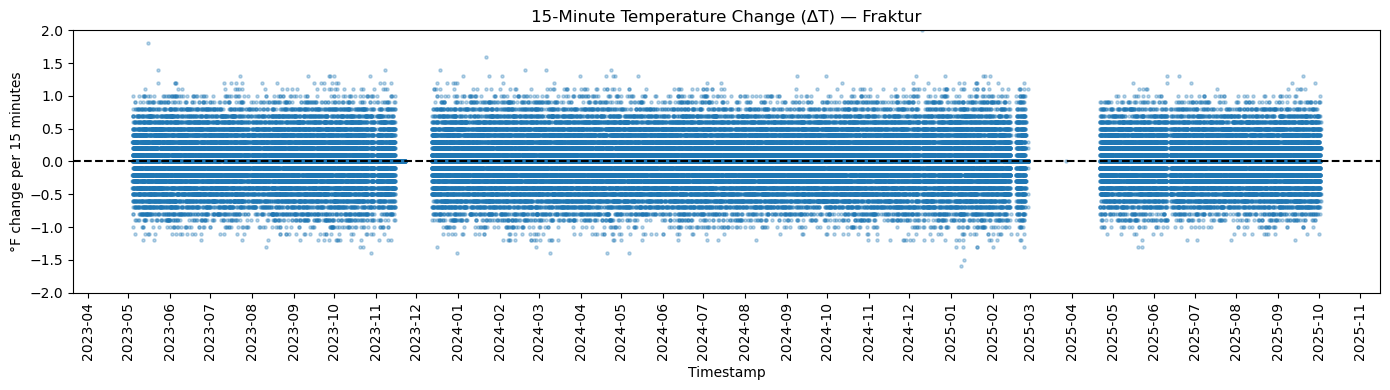

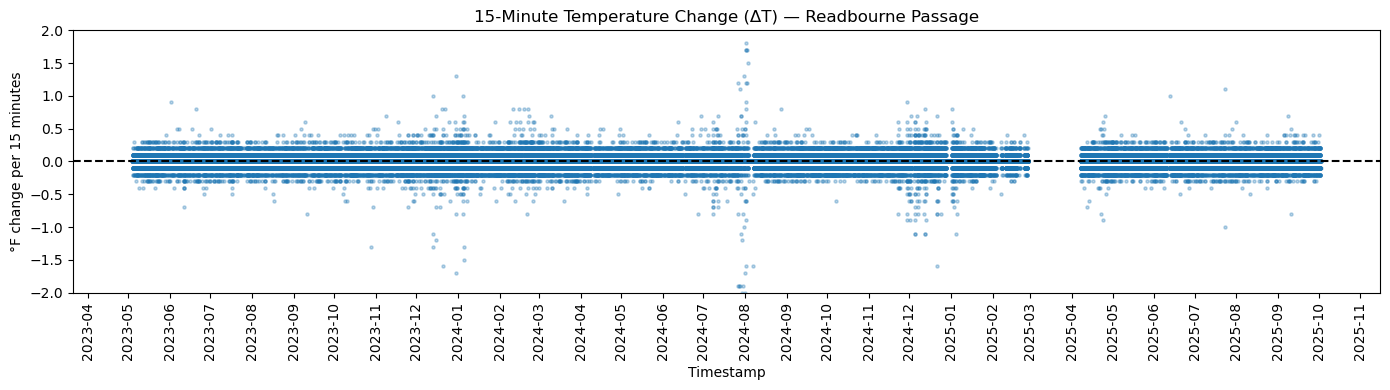

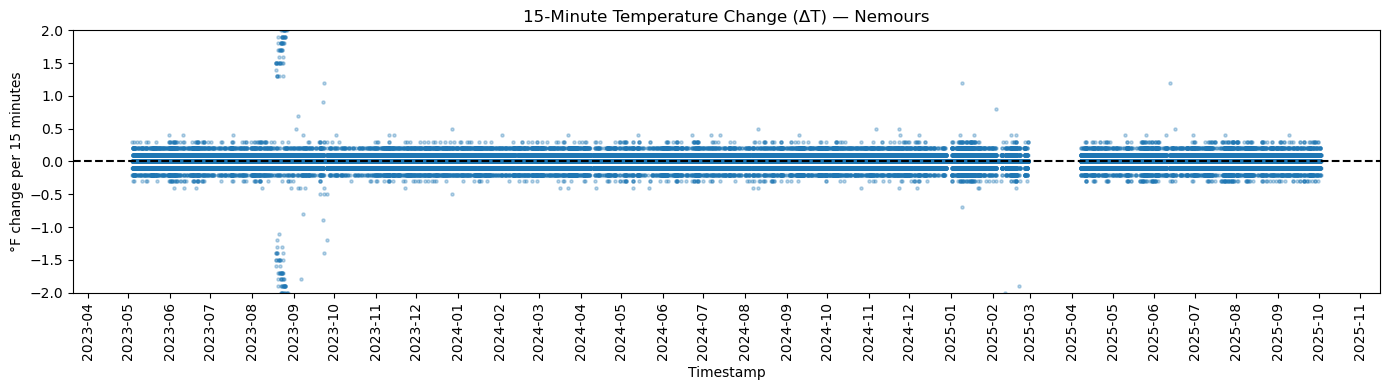

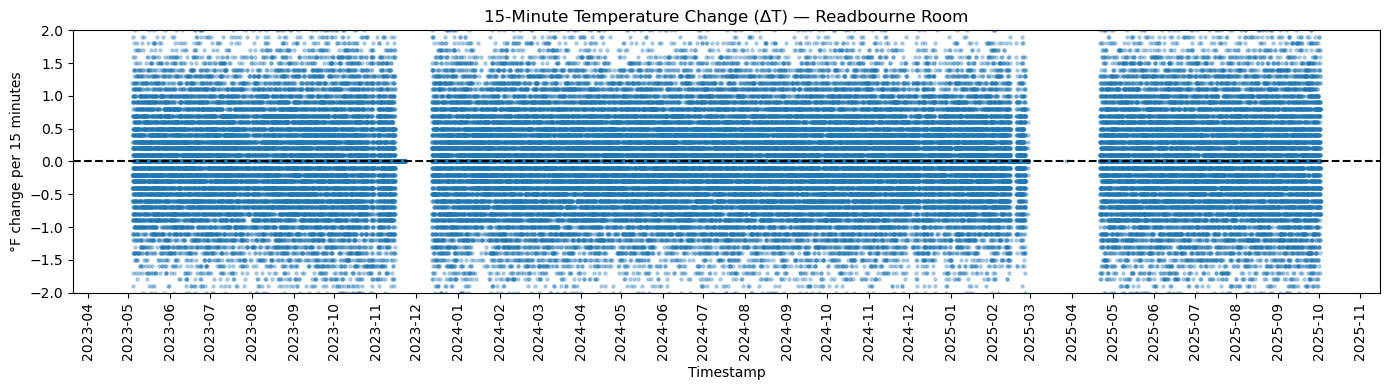

In [169]:
plot_rate_15min("Cecil", clean_15)
plot_rate_15min("Fraktur", clean_15)
plot_rate_15min("Readbourne Passage", clean_15)
plot_rate_15min("Nemours", clean_15)
plot_rate_15min("Readbourne Room", clean_15)


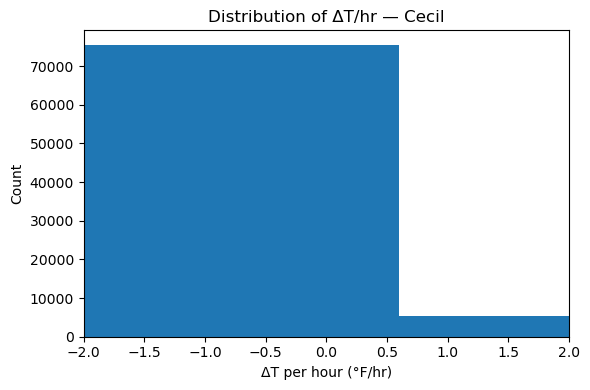

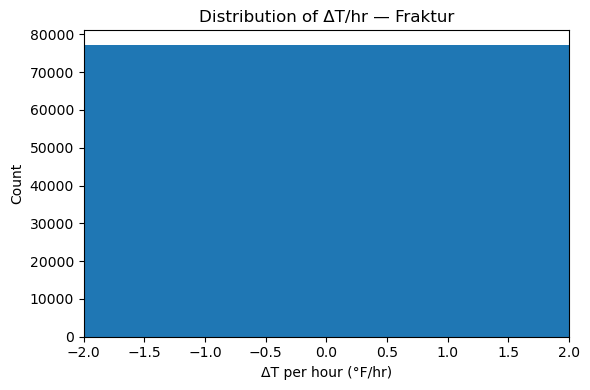

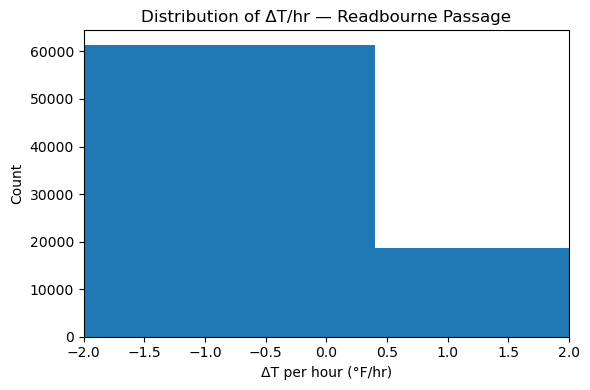

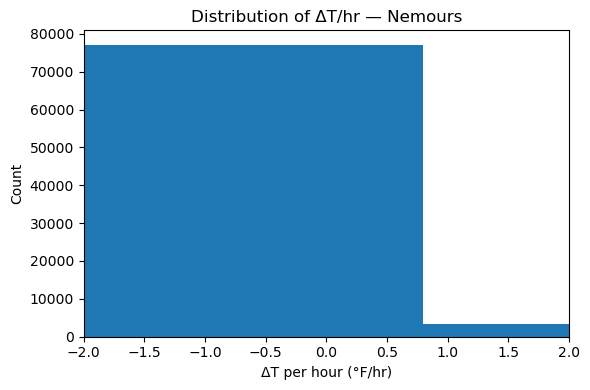

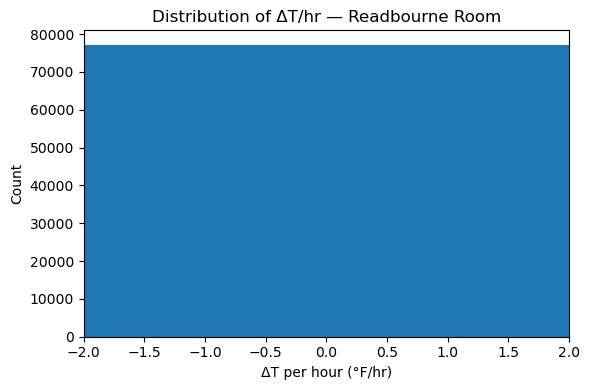

In [128]:
plot_rate_hist("Cecil")        
plot_rate_hist("Fraktur")
plot_rate_hist("Readbourne Passage")
plot_rate_hist("Nemours")
plot_rate_hist("Readbourne Room")


In [170]:
temp_clean = temp_all.dropna(subset=["temp_F"]).copy()

rooms = temp_clean["Room"].unique()
rooms

array(['Cecil', 'Fraktur', 'Readbourne Passage', 'Nemours',
       'Readbourne Room'], dtype=object)

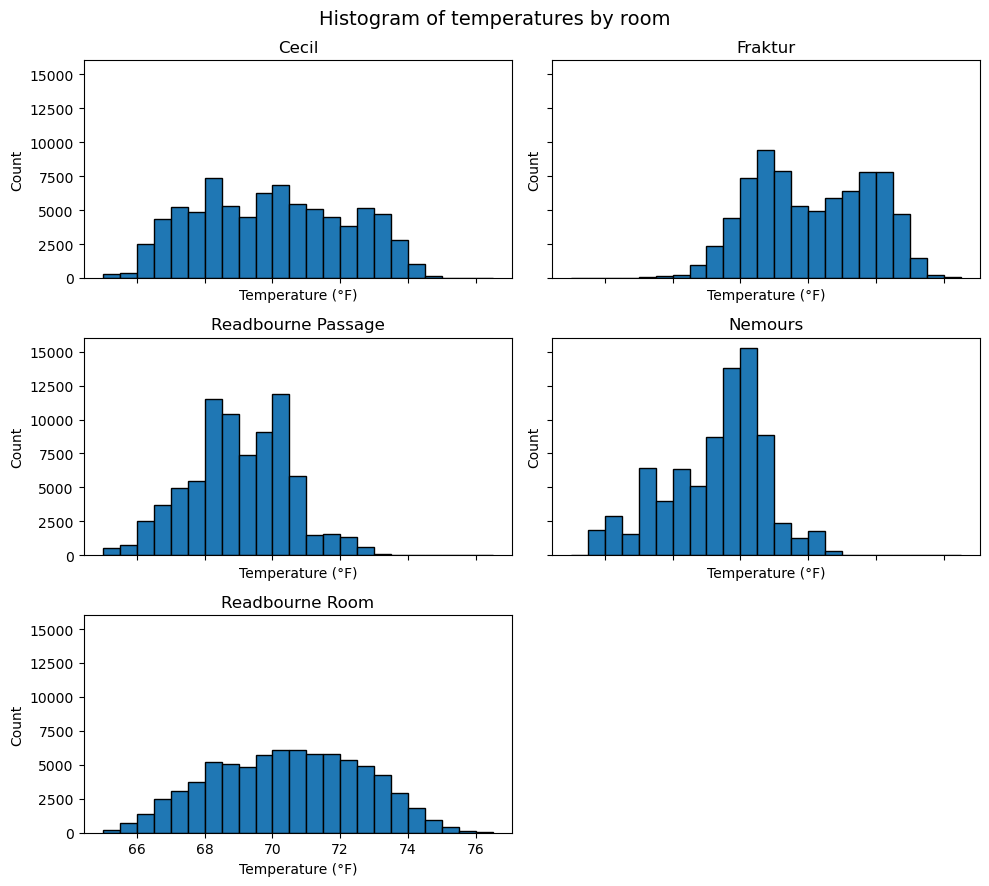

In [171]:
bins = np.arange(65, 77, 0.5)  # 65–76.5°F in 0.5°F steps

n_rooms = len(rooms)
n_cols = 2
n_rows = int(np.ceil(n_rooms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for ax, room in zip(axes, rooms):
    r = temp_clean[temp_clean["Room"] == room]
    ax.hist(r["temp_F"], bins=bins, edgecolor="black")
    ax.set_title(room)
    ax.set_xlabel("Temperature (°F)")
    ax.set_ylabel("Count")

# Hide any unused subplots
for ax in axes[len(rooms):]:
    ax.set_visible(False)

fig.suptitle("Histogram of temperatures by room", fontsize=14)
plt.tight_layout()
plt.show()

In [102]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_temp(room, month=None):
    """
    Plot actual temperature (°F) over time for a given room.
    If month is like '2023-08', it restricts to that month.
    """
    df = clean[clean["Room"] == room].copy()
    df = df.sort_values("timestamp")

    if month is not None:
        df = df[df["timestamp"].dt.strftime("%Y-%m") == month]

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df["timestamp"], df["temp_F"], lw=0.7)

    title = f"Temperature (°F) — {room}"
    if month is not None:
        title += f" ({month})"
    ax.set_title(title)
    ax.set_ylabel("Temperature (°F)")
    ax.set_xlabel("Timestamp")

    # FIXED y-axis range to confirm the temp never went high
    ax.set_ylim(60, 80)

    # x-axis formatting
    if month is None:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


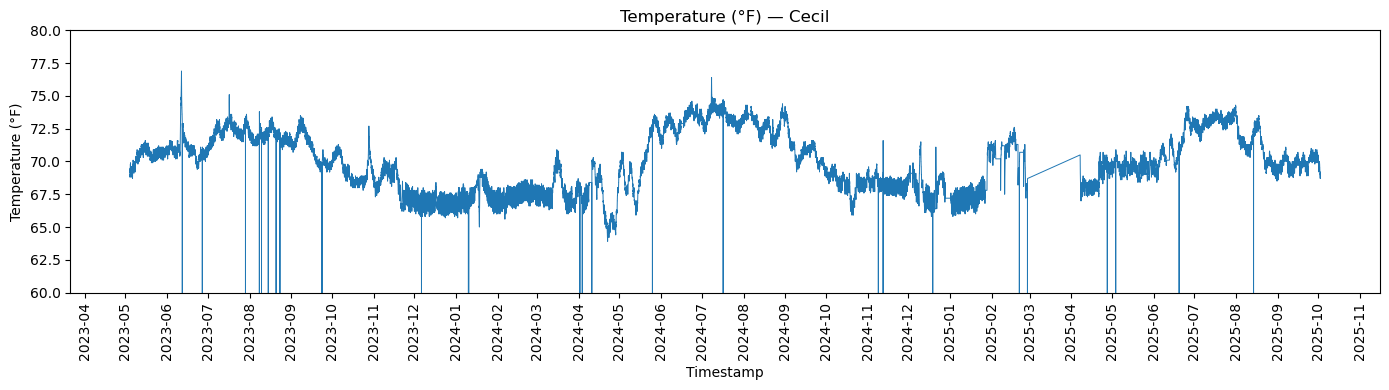

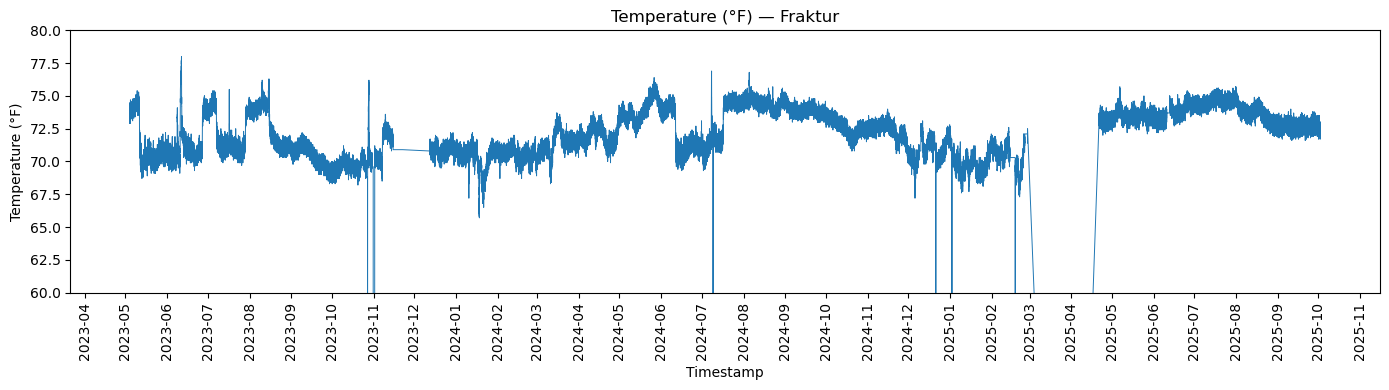

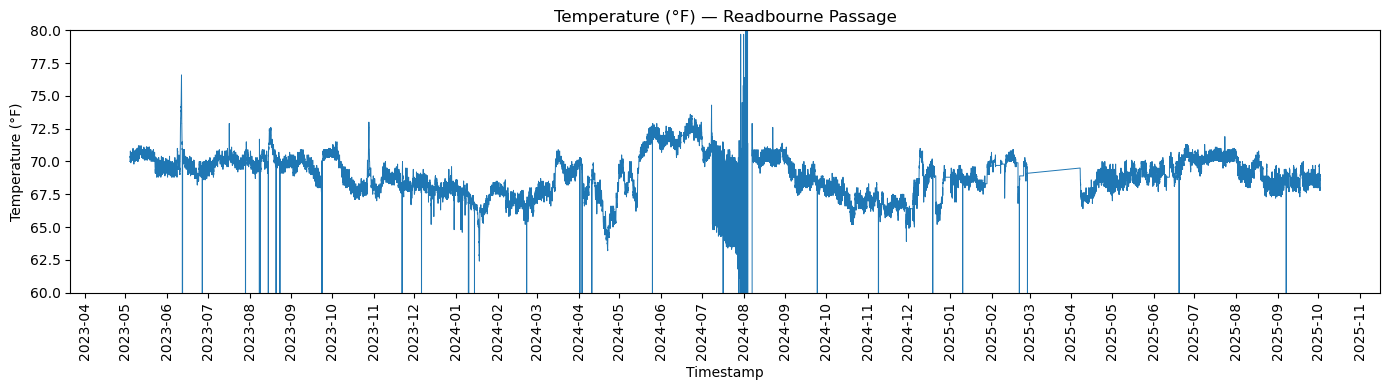

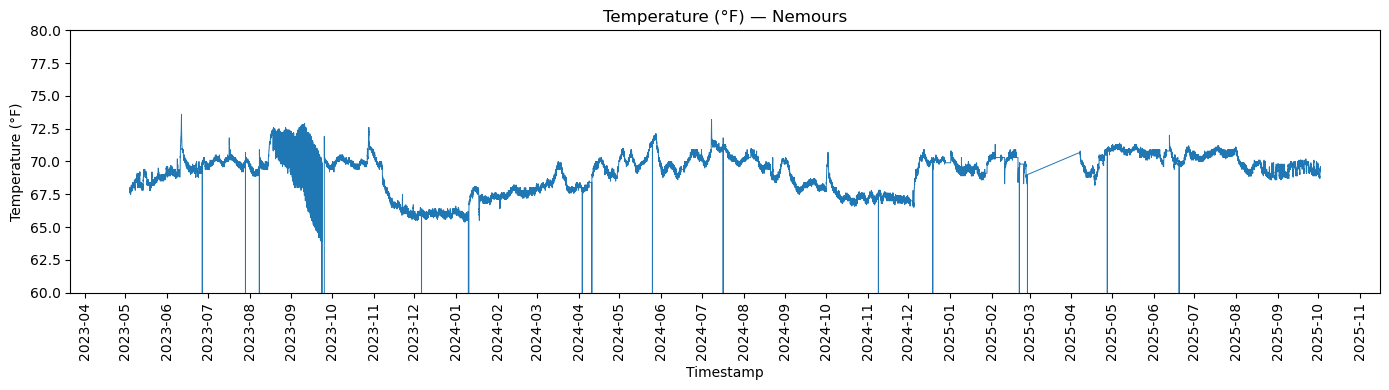

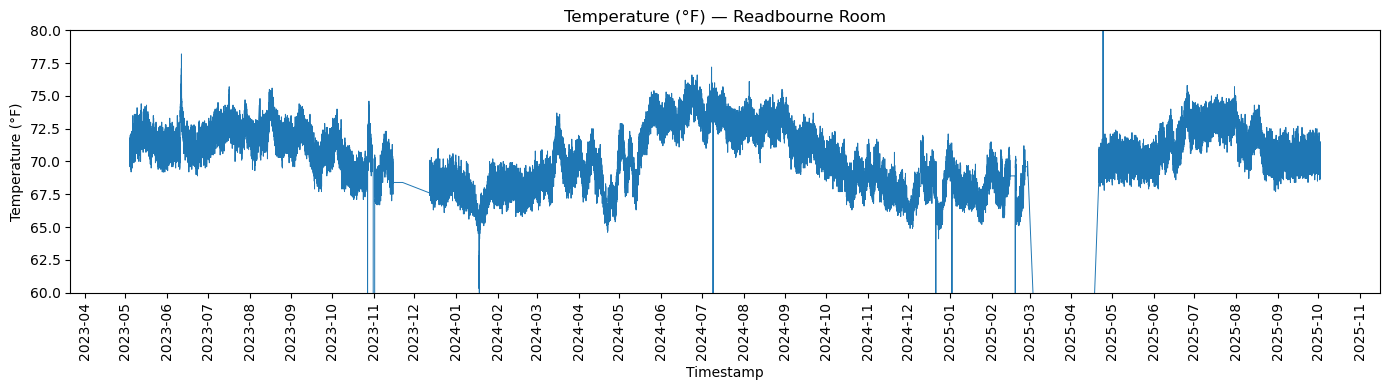

In [103]:
plot_temp("Cecil")           
plot_temp("Fraktur")  
plot_temp("Readbourne Passage")
plot_temp("Nemours")
plot_temp("Readbourne Room")
